# 使用 Keras 搭建人工神经网络

### 一、查看 tensorflow 是否安装成功

In [17]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

In [3]:
tf.__version__

'1.13.1'

In [4]:
keras.__version__

'2.2.4-tf'

### 二、使用 Keras 加载数据集

Keras 提供一些实用的函数用来获取和加载常见的数据集，包括 MNIST、Fashion MNIST 和第 2 章用过的加州房产数据集。加载 Fashion MNIST：

In [9]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

当使用 Keras 加载 MNIST 或 Fashion MNIST 时，和 Scikit-Learn 加载数据的一个重要区别是，每张图片是28 × 28的数组，而不是大小是 784 的 1D 数组。另外像素的强度是用整数（0 到 255）表示的，而不是浮点数（0.0 到 255.0）。看下训练集的形状和类型：

In [11]:
X_train_full.shape

(60000, 28, 28)

In [18]:
X_train_full.dtype

dtype('uint8')

该数据集已经分成了训练集和测试集，但没有验证集。所以要建一个验证集，另外，因为要用梯度下降训练神经网络，必须要对输入特征进行缩放。简单起见，通过除以 255.0 将强度范围变为 0-1：

In [22]:
X_valid,X_train = X_train_full[:5000]/255.0,X_train_full[5000:]/255.0
y_valid,y_train = y_train_full[:5000],y_train_full[5000:]

对于 MNIST，当标签等于 5 时，表明图片是手写的数字 5。但对于 Fashion MNIST，需要分类名的列表：

In [20]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"] 

例如，训练集的第一张图片表示外套：

In [23]:
class_names[y_train[0]]

'Coat'

### 三、用顺序 API 创建模型

In [26]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300,activation='relu'))
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dense(10,activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


逐行看下代码：

* 第一行代码创建了一个顺序 模型，这是 Keras 最简单的模型，是由单层神经元顺序连起来的，被称为顺序 API；


* 接下来创建了第一层，这是一个 `Flatten层` ，它的作用是将每个输入图片转变为 1D 数组：如果输入数据是 `X`，该层则计算 `X.reshape(-1, 1)`。该层没有任何参数，只是做一些简单预处理。因为是模型的第一层，必须要指明 `input_shape`，`input_shape` 不包括批次大小，只是实例的形状。另外，第一层也可以是 `keras.layers.InputLayer`，设置 `input_shape=[28,28]`;


* 然后，添加了一个有 300 个神经元的紧密层，激活函数是 ReLU。每个紧密层只负责自身的权重矩阵，权重矩阵是神经元与输入的所有连接权重。紧密层还要负责偏置项（每个神经元都有一个偏置项）向量。当紧密层收到输入数据时，就利用如下公式进行计算：

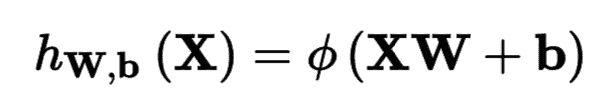

* 接着再添加第二个紧密层，激活函数仍然是 ReLU；


* 最后，加上一个拥有 10 个神经元的输出层（每有一个类就要有一个神经元），激活函数是 softmax（保证输出的概率和等于 1，因为就只有这是个类，具有排他性）。

模型的 `summary()` 方法可以展示所有层，包括每个层的名字（名字是自动生成的，除非建层时指定名字），输出的形状（ `None` 代表批次大小可以是任意值），和参数的数量。最后会输出所有参数的数量，包括可训练和不可训练参数。

这章只有可训练参数（第 11 章可以看到不可训练参数的例子）：

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


紧密层通常有许多参数。比如，第一个隐含层有 `784 × 300` 个连接权重，再加上 `300` 个偏置项，总共有 `235500` 个参数。这么多参数可以让模型具有足够的灵活度以拟合训练数据，但也意味着可能有过拟合的风险，特别是当训练数据不足时。后面再讨论这个问题。

使用属性，获取神经层很容易，可以通过索引或名称获取对应的层：

In [29]:
model.layers

In [32]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [33]:
model.get_layer('dense') is hidden1

True

可以用 `get_weights()` 和 `set_weights()` 方法，获取神经层的所有参数。对于紧密层，参数包括 `连接权重` 和 `偏置项`：

In [34]:
weights,biases = hidden1.get_weights()
weights

array([[-0.0204033 ,  0.01251883, -0.03042106, ..., -0.06858013,
        -0.00748003,  0.01333757],
       [ 0.04203597, -0.05735145, -0.01066719, ..., -0.00935526,
         0.02611314, -0.06450643],
       [-0.00057121,  0.05467187, -0.06485866, ...,  0.01020288,
        -0.03086314,  0.01780966],
       ...,
       [-0.03885067,  0.06087716, -0.04061935, ..., -0.05019247,
         0.03506415, -0.01687093],
       [ 0.05755325, -0.04045345,  0.07282361, ...,  0.06137431,
         0.07331294,  0.07183865],
       [ 0.03034234, -0.07258083, -0.01201869, ...,  0.06633256,
        -0.02958009, -0.02477586]], dtype=float32)

In [36]:
weights.shape  # 参数 w

(784, 300)

In [37]:
biases.shape  # 偏置项 b

(300,)

紧密层是随机初始化连接权重的（为了避免对称性），偏置项则是 0。如果想使用不同的初始化方法，可以在创建层时设置 `kernel_initializer`（核是连接矩阵的另一个名字）或 `bias_initializer` 。第 11 章会进一步讨论初始化器，初始化器的完整列表见 [这里](https://links.jianshu.com/go?to=https%3A%2F%2Fkeras.io%2Finitializers%2F)。

#### 笔记：

权重矩阵的形状取决于输入的数量。这就是为什么要在创建 `Sequential模型` 的第一层时指定 `input_shape` 。但是，如果不指定形状也没关系：Keras 会在真正搭建模型前一直等待，直到弄清输入的形状（输入真实数据时，或调用 `build()` 方法时）。在搭建模型之前，神经层是没有权重的，也干不了什么事（比如打印模型概要或保存模型）。`所以如果在创建模型时知道输入的形状，最好就设置好。`

### 四、编译模型

创建好模型之后，必须调用 `compile()` 方法，设置损失函数和优化器。另外，还可以指定训练和评估过程中要计算的额外指标的列表：

In [39]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

#### 笔记：

使用 `loss="sparse_categorical_crossentropy"` 等同于 `loss=keras.losses.sparse_categorical_crossentropy` 。

相似的，`optimizer="sgd"` 等同于 `optimizer=keras.optimizers.SGD()` ，`metrics=["accuracy"]` 等同于 `metrics=[keras.metrics.sparse_categorical_accuracy]`。

后面还会使用其他的 `损失函数` 、`优化器` 和 `指标`，它们的完整列表见 [这里](https://links.jianshu.com/go?to=https%3A%2F%2Fkeras.io%2Flosses)、 [这里](https://links.jianshu.com/go?to=https%3A%2F%2Fkeras.io%2Foptimizers)、和[这里](https://links.jianshu.com/go?to=https%3A%2F%2Fkeras.io%2Fmetrics。)

解释下这段代码。首先，因为使用的是稀疏标签（每个实例只有一个目标类的索引，在这个例子中，目标类索引是 0 到 9），且就是这十个类，没有其它的，所以使用的是 `"sparse_categorical_crossentropy"` 损失函数。如果每个实例的每个类都有一个目标概率（比如独热向量，`[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]` ，来表示类 3），则就要使用 `"categorical_crossentropy"` 损失函数。如果是做二元分类（有一个或多个二元标签），输出层就得使用 `"sigmoid"` 激活函数，损失函数则变为 `"binary_crossentropy"`。

### 五、训练和评估模型

可以训练模型了。只需调用 fit() 方法：

In [40]:
history = model.fit(X_train,y_train,epochs=30,validation_data=(X_valid,y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 7s 125us/sample - loss: 0.7274 - acc: 0.7609 - val_loss: 0.5115 - val_acc: 0.8300
Epoch 2/30
55000/55000 [==============================] - 6s 105us/sample - loss: 0.4882 - acc: 0.8284 - val_loss: 0.4651 - val_acc: 0.8350
Epoch 3/30
55000/55000 [==============================] - 6s 102us/sample - loss: 0.4413 - acc: 0.8457 - val_loss: 0.4275 - val_acc: 0.8570
Epoch 4/30
55000/55000 [==============================] - 6s 106us/sample - loss: 0.4137 - acc: 0.8551 - val_loss: 0.4369 - val_acc: 0.8382
Epoch 5/30
55000/55000 [==============================] - 6s 103us/sample - loss: 0.3942 - acc: 0.8613 - val_loss: 0.3766 - val_acc: 0.8748
Epoch 6/30
55000/55000 [==============================] - 6s 102us/sample - loss: 0.3777 - acc: 0.8669 - val_loss: 0.3730 - val_acc: 0.8698
Epoch 7/30
55000/55000 [==============================] - 6s 104us/sample - loss: 0.3662 - acc: 0.8705 - val_lo

这里，向 `fit()` 方法传递了输入特征 `(X_train)` 和目标类 `(y_train)`，还要要训练的周期数（不设置的话，默认的周期数是 1，肯定是不能收敛到一个好的解的）。另外还传递了验证集（它是可选的）。Keras 会在每个周期结束后，测量损失和指标，这样就可以监测模型的表现。如果模型在训练集上的表现优于在验证集上的表现，可能模型在训练集上就过拟合了（或者就是存在 bug，比如训练集和验证集的数据不匹配）。

#### 提示：

除了通过参数 `validation_data` 传递验证集，也可以通过参数 `validation_split` 从训练集分割出一部分作为验证集。比如，`validation_split=0.1` 可以让 `Keras` 使用训练数据（打散前）的末尾 10% 作为验证集。

如果训练集非常倾斜，一些类过渡表达，一些欠表达，在调用 `fit()` 时最好设置 `class_weight` 参数，可以加大欠表达类的权重，减小过渡表达类的权重。Keras 在计算损失时，会使用这些权重。如果每个实例都要加权重，可以设置 `sample_weight`（这个参数优先于 `class_weight` ）。如果一些实例的标签是通过专家添加的，其它实例是通过众包平台添加的，最好加大前者的权重，此时给每个实例都加权重就很有必要。通过在 `validation_data` 元组中，给验证集加上样本权重作为第三项，还可以给验证集添加样本权重。

`fit()` 方法会返回 `History` 对象，包含：`训练参数（history.params）` 、 `周期列表（history.epoch）`、以及最重要的包含训练集和验证集的每个周期后的损失和指标的字典 `（history.history）`。如果用这个字典创建一个 `pandas` 的 `DataFrame` ，然后使用方法 `plot()` ，就可以画出学习曲线，见图 ：

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

In [54]:
# history.history #包含训练集和验证集的每个周期后的损失和指标的字典 

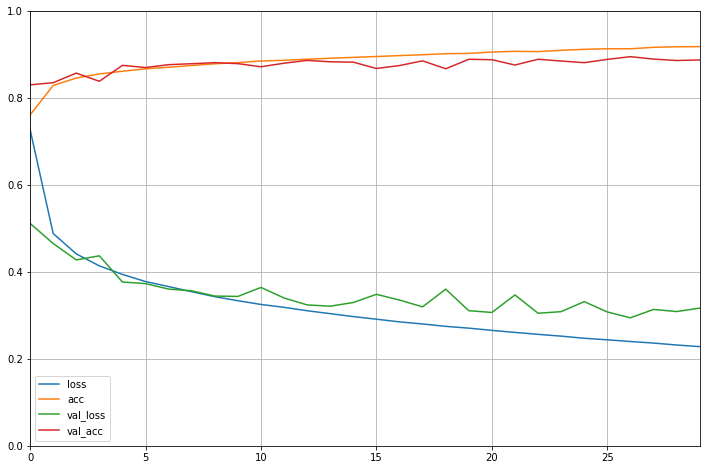

In [56]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True) # 是否加上网格
plt.gca().set_ylim(0,1)
plt.show()

记录了每个周期的平均训练损失和准确率，验证损失和准确率

可以看到，训练准确率和验证准确率稳步提高，训练损失和验证损失持续下降。另外，验证曲线和训练曲线靠的很近，意味着没有什么过拟合。在这个例子中，在训练一开始时，模型在验证集上的表现由于训练集。

`但实际情况是，验证误差是在每个周期结束后算出来的，而训练误差在每个周期期间，用流动平均误差算出来的。所以训练曲线（译者注，图中橙色的那条）实际应该向左移动半个周期。移动之后，就可以发现在训练开始时，训练和验证曲线几乎是完美重合起来的。`

#### 提示：

在绘制训练曲线时，应该向左移动半个周期。

通常只要训练时间足够长，训练集的表现就能超越验证集。从图中可以看到，验证损失仍然在下降，模型收敛的还不好，所以训练应该持续下去。只需要再次调用方法 `fit()` 即可，因为 Keras 可以从断点处继续（验证准确率可以达到 89%。）

如果仍然对模型的表现不满意，就需要调节超参数了。首先是学习率。如果调节学习率没有帮助，就尝试换一个优化器（记得再调节任何超参数之后都重新调节学习率）。如果效果仍然不好，就调节模型自身的超参数，比如层数、每层的神经元数，每个隐藏层的激活函数。还可以调节其它超参数，比如批次大小（通过 `fit()` 的参数 `batch_size` ，默认是 `32`）。本章末尾还会调节超参数。当对验证准确率达到满意之后，就可以用测试集评估 `泛化误差` 。只需使用 `evaluate()` 方法（`evaluate()` 方法包含参数 `batch_size` 和 `sample_weight`）：

一、经验误差（训练误差）与泛化误差

* 经验误差（训练误差）：模型在训练集上的误差称为“经验误差”（empirical error）或者“训练误差”“training error”。


* 泛化误差：模型在新样本集（测试集）上的误差称为“泛化误差”（generalization error）。
